# Testing bounding box conversion & IOU

* Code partially taken from [Oriented RepPoints](https://github.com/LiWentomng/OrientedRepPoints/tree/main/mmdet/ops).

In [348]:
%reload_ext autoreload
%autoreload 2

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from math import pi
from obb.utils.box_ops import *

# set plot deafult values
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('font', family='serif', size=11)
plt.matplotlib.rc('legend', fontsize=11)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['ytick.direction'] = 'inout'
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#ad8966', ]

### Generating random point clusters

In [13]:
def gen_random_clusters(num_clusters=10, points_per_cluster=9, im_dim=(256, 256), cluster_dim=(40, 40)):
    """ Generates a [B, N, 2] tensor with B clusters, N points each."""

    x_im, y_im = im_dim
    x_cluster, y_cluster = cluster_dim

    # Generate random centers
    x0_lst = torch.randint(0, x_im, (num_clusters,))
    y0_lst = torch.randint(0, y_im, (num_clusters,))

    # Generate random angles uniformly-distributed in the interval [-0.5*pi,0.5*pi)
    theta_lst = torch.rand((num_clusters,)) * pi - 0.5 * pi
    c_lst = torch.cos(theta_lst)
    s_lst = torch.sin(theta_lst)

    # Generate random cluster dimensions
    x_scale_lst = torch.randint(5, x_cluster, (num_clusters,))
    y_scale_lst = torch.randint(5, y_cluster, (num_clusters,))

    # Generate the random points for each cluster
    point_lst = []

    for x0, y0, c, s, x_scale, y_scale in zip(x0_lst, y0_lst, c_lst, s_lst, x_scale_lst, y_scale_lst):
        # Generate random offsets
        dx = torch.randint(0, x_scale, (points_per_cluster,))
        dy = torch.randint(0, y_scale, (points_per_cluster,))

        # Apply rotation
        dx_rot = c * dx - s * dy
        dy_rot = s * dx + c * dy

        points = torch.stack([x0 + dx_rot, y0 + dy_rot], dim=1) # [N, 2]
        point_lst.append(points)

    return torch.stack(point_lst) # [B, N, 2]

### Computing convex hull

Cluster tensor shape: torch.Size([40, 9, 2])
Elapsed time: 0.02 sec
Convex hull tensor shape: torch.Size([40, 9, 2])
Size tensor shape: torch.Size([40])


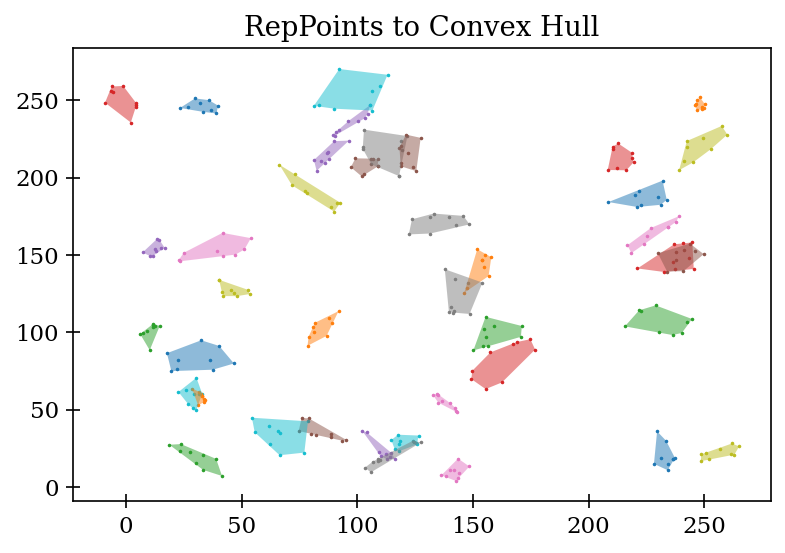

In [14]:
clusters = gen_random_clusters(num_clusters=40)
print(f'Cluster tensor shape: {clusters.shape}')

t0 = time.process_time()
hull, sizes = convex_hull(clusters)
t1 = time.process_time()
dt = t1 - t0

print(f'Elapsed time: {dt:.2f} sec')
print(f'Convex hull tensor shape: {hull.shape}')
print(f'Size tensor shape: {sizes.shape}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for cluster in clusters:
    sc = ax.scatter(cluster[:, 0], cluster[:, 1], s=0.5)

for cluster, size in zip(hull, sizes):
    ax.fill(cluster[:size, 0], cluster[:size, 1], alpha=0.5)

plt.title('RepPoints to Convex Hull')
plt.show()

### Finding bounding rectangle with minimal area

Elapsed time: 0.03 sec
Minimal bounding rectangle shape: torch.Size([40, 4, 2])


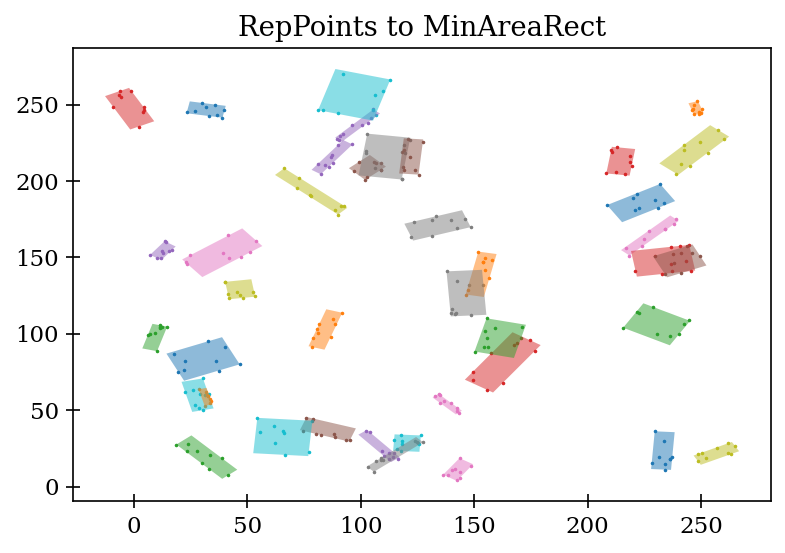

In [15]:
t0 = time.process_time()
rects = min_area_rect(clusters)
t1 = time.process_time()
dt = t1 - t0

print(f'Elapsed time: {dt:.2f} sec')
print(f'Minimal bounding rectangle shape: {rects.shape}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for cluster in clusters:
    sc = ax.scatter(cluster[:, 0], cluster[:, 1], s=0.5)

for rect in rects:
    ax.fill(rect[:, 0], rect[:, 1], alpha=0.5)

plt.title('RepPoints to MinAreaRect')
plt.show()

### Testing out-of-box loss

Rectangle points: tensor([[16.9456, 27.2415],
        [14.6646, 25.0513],
        [17.9499, 21.6298],
        [20.2309, 23.8200]])
Outlier points: tensor([[17.8489, 27.6705],
        [16.4258, 23.6736],
        [16.5166, 28.1448],
        [21.3714, 24.9151],
        [15.9969, 24.5769]])
Distances: tensor([9.7401e-01, 1.1892e-08, 1.0000e+00, 1.2574e+00, 1.1892e-08])
Inside box: tensor([False,  True, False, False,  True])


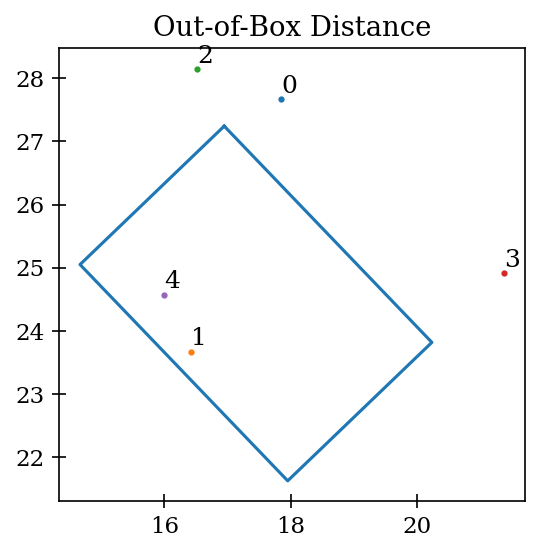

In [21]:
N = 1
B = 5

clusters = gen_random_clusters(num_clusters=N, points_per_cluster=B+4, im_dim=(40, 40), cluster_dim=(10, 10))
polys, points = clusters[..., :4, :], clusters[..., 4:, :]
rects = min_area_rect(polys).squeeze()
points = points.squeeze()
distances = torch.sqrt(out_of_box_distance(points, rects))
inside_box = is_inside_box(points, rects)

print(f'Rectangle points: {rects}')
print(f'Outlier points: {points}')
print(f'Distances: {distances}')
print(f'Inside box: {inside_box}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for i in range(B):
    ax.scatter(points[i, 0], points[i, 1], s=4)
    ax.text(points[i, 0], points[i, 1] + 0.1, i, fontsize=12)

ax.plot(torch.cat((rects[:, 0], rects[0, 0].reshape(1))), torch.cat((rects[:, 1], rects[0, 1].reshape(1))))

ax.set_aspect('equal', 'box')

plt.title('Out-of-Box Distance')
plt.show()

### Testing Gaussian conversion functions

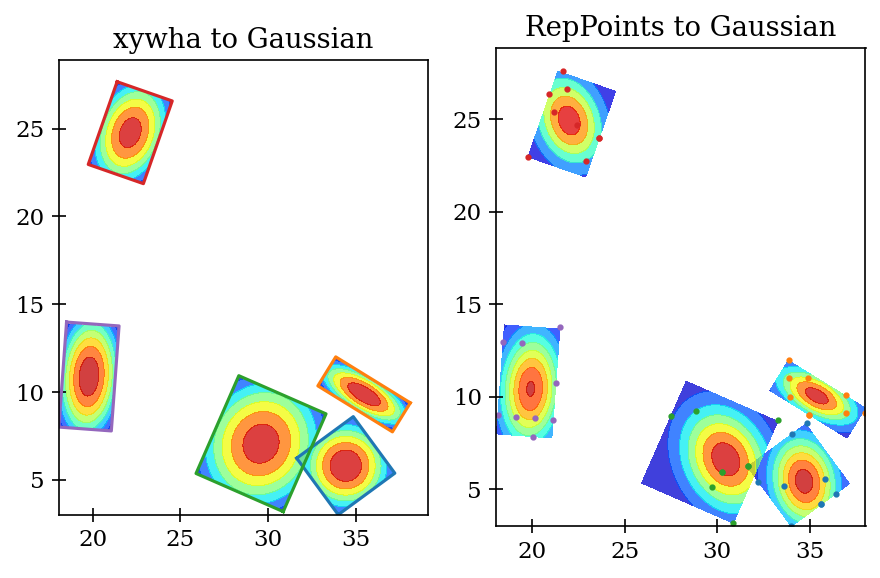

In [314]:
N = 5
B = 9

clusters = gen_random_clusters(num_clusters=N, points_per_cluster=B, im_dim=(40, 40), cluster_dim=(10, 10))
rects = min_area_rect(clusters)

rects_xywha = torch.zeros(N, 6)
for i, rect in enumerate(rects):
    rects_xywha[i] = torch.Tensor(xyxy_to_xywha(rect))

mu1, S1 = xywha_to_gaussian(rects_xywha)
mu2, S2 = rep_points_to_gaussian(clusters)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i, (rect, cluster) in enumerate(zip(rects, clusters)):
    x0, y0, w, h, c, s = rects_xywha[i]
    x, y = np.arange(-0.5*w, 0.5*w, 0.1), np.arange(-0.5*h, 0.5*h, 0.1)
    xx, yy = np.meshgrid(x, y)
    xx, yy = c * xx - s * yy, s * xx + c * yy
    xx += x0
    yy += y0
    pos = np.dstack((xx, yy))
    rv1 = multivariate_normal(mean=mu1[i], cov=S1[i])
    rv2 = multivariate_normal(mean=mu2[i], cov=S2[i])

    ax1.contourf(xx, yy, rv1.pdf(pos), alpha=0.75, cmap='jet')
    ax2.contourf(xx, yy, rv2.pdf(pos), alpha=0.75, cmap='jet')
    ax1.plot(torch.cat((rect[:, 0], rect[0, 0].reshape(1))), torch.cat((rect[:, 1], rect[0, 1].reshape(1))))
    ax2.scatter(cluster[:, 0], cluster[:, 1], s=4)

ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')

ax1.set_title('xywha to Gaussian')
ax2.set_title('RepPoints to Gaussian')
plt.tight_layout()
plt.show()

### Testing KL divergence function

KL divergence: 4.2740702629089355


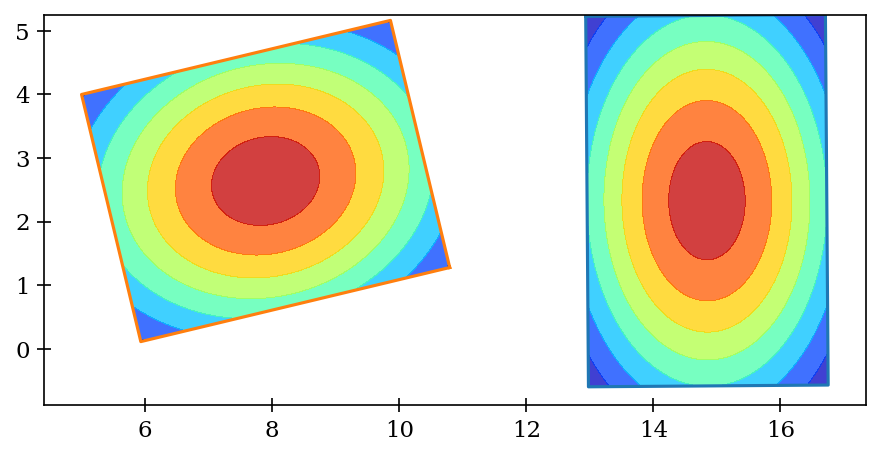

In [409]:
N = 2
B = 9

clusters = gen_random_clusters(num_clusters=N, points_per_cluster=B, im_dim=(10, 10), cluster_dim=(10, 10))
rects = min_area_rect(clusters)

mu, S = rep_points_to_gaussian(rects)
mu1, mu2 = mu
S1, S2 = S

kl_div = kl_divergence_gaussian(mu1, S1, mu2, S2)
print(f'KL divergence: {kl_div}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for i, (rect, cluster) in enumerate(zip(rects, clusters)):
    x0, y0, w, h, c, s = xyxy_to_xywha(rect)
    x, y = np.arange(-0.5*w, 0.5*w, 0.01), np.arange(-0.5*h, 0.5*h, 0.01)
    xx, yy = np.meshgrid(x, y)
    xx, yy = c * xx - s * yy, s * xx + c * yy
    xx += x0
    yy += y0
    pos = np.dstack((xx, yy))
    rv = multivariate_normal(mean=mu[i], cov=S[i])

    ax.contourf(xx, yy, rv.pdf(pos), alpha=0.75, cmap='jet')
    ax.plot(torch.cat((rect[:, 0], rect[0, 0].reshape(1))), torch.cat((rect[:, 1], rect[0, 1].reshape(1))))

ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()